## Imports

In [97]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

In [98]:
Xtr = pd.read_csv('data/Xtr.csv',header=None,sep=',',usecols=range(3072))
Xte = pd.read_csv('data/Xte.csv',header=None,sep=',',usecols=range(3072))
Ytr_ = pd.read_csv('data/Ytr.csv')#, index_col = None, header = None)

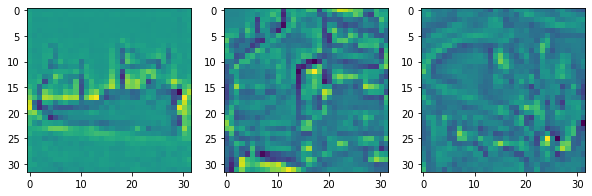

In [103]:
Xtr_ = np.array(Xtr).reshape(5000, 3,32, 32)
X = Xtr_.swapaxes(1,2).swapaxes(2,3)
fig, ax = plt.subplots(1, 3, figsize = (10,10))
for i, img in enumerate(X[:3]):
    #img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    ax[i].imshow(rgb2gray(img), interpolation='nearest')
plt.show()

## Preprocessing

In [105]:
def preprocess_zero_one(X):
    res = X.copy()
    for i in range(len(X)):
        res[i] = (X[i] - np.min(X[i])) / (np.max(X[i]) - np.min(X[i]))
    return res
X_n = preprocess_zero_one(X)

SyntaxError: invalid syntax (342595949.py, line 4)

In [ ]:
def preprocess_normal(X):
    res = X.copy()
    for i in range(len(X)):
        res[i] = (X[i] - np.min(X[i])) / (np.max(X[i]) - np.min(X[i]))
    return res

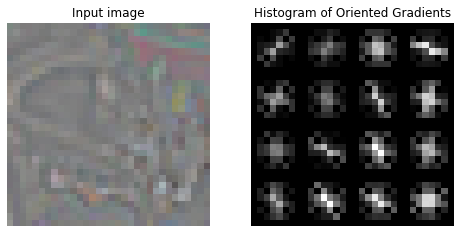

In [129]:
from skimage.feature import hog
from skimage import data, exposure


image = (X[2]+0.5)

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [130]:
X_hog = [hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=False, channel_axis=-1) for image in (X+0.5)]

In [137]:
X_hog = np.array(X_hog)

## with sklearn

In [138]:
from sklearn import svm
from sklearn.model_selection import train_test_split

In [37]:
Xtr_gray = np.array([rgb2gray(img) for img in X])

In [45]:
Xtr_gray = Xtr_gray.reshape((5000,1024))

In [139]:
Ytr = np.array(Ytr_['Prediction'])

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_hog, Ytr, test_size=0.33, random_state=42)

In [141]:
clf = svm.SVC()

In [142]:
clf.fit(X_train,y_train)

SVC()

In [143]:
clf.score(X_test,y_test)

0.3927272727272727

## with PCA

In [55]:
from time import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

In [56]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d images" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, 32,32))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 150 eigenfaces from 3350 images
done in 0.542s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.041s


In [57]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 121.485s
Best estimator found by grid search:
SVC(C=27315.349604714527, class_weight='balanced', gamma=0.006534113583101998)


In [62]:
target_names=[str(x) for x in np.unique(y_test)]

Predicting people's names on the test set
done in 1.175s
              precision    recall  f1-score   support

           0       0.19      0.28      0.23       165
           1       0.39      0.24      0.30       168
           2       0.17      0.27      0.21       157
           3       0.18      0.21      0.20       154
           4       0.14      0.19      0.16       167
           5       0.19      0.13      0.16       174
           6       0.20      0.13      0.15       189
           7       0.26      0.21      0.23       155
           8       0.28      0.27      0.27       169
           9       0.27      0.20      0.23       152

    accuracy                           0.21      1650
   macro avg       0.23      0.21      0.21      1650
weighted avg       0.23      0.21      0.21      1650



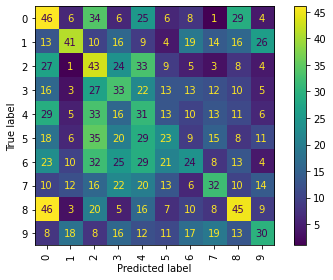

In [63]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [64]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

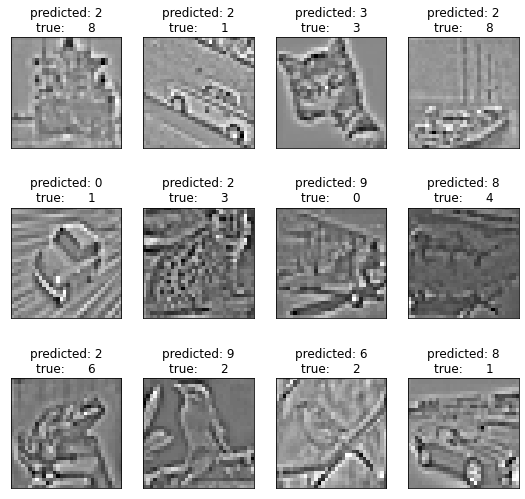

In [66]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, 32, 32)

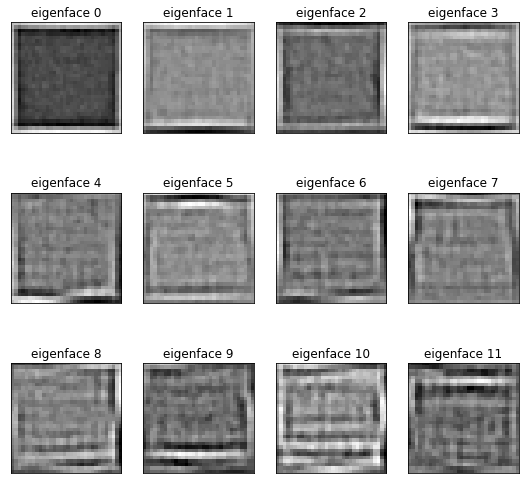

In [68]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 32, 32)

plt.show()

In [212]:
from sklearn.decomposition import PCA, KernelPCA

In [213]:
pca = KernelPCA(n_components=2000, kernel="rbf", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)
Xtr = np.array(Xtr)
Xtr_pca = pca.fit_transform(Xtr)

In [214]:
Ytr = np.array(Ytr_['Prediction'])

In [215]:
X_train, X_test, y_train, y_test = train_test_split(Xtr_pca, Ytr, test_size=0.33, random_state=0)

In [216]:
clf = svm.SVC(kernel='poly', degree=6)

In [217]:
clf.fit(X_train,y_train)

SVC(degree=6, kernel='poly')

In [218]:
clf.score(X_test,y_test)# sample_weight=None)[source]¶

0.09696969696969697

## Denoising

In [191]:
X_reconstructed_kernel_pca = pca.inverse_transform(Xtr_pca)

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X_reconstructed_kernel_pca, Ytr, test_size=0.33, random_state=32)

In [193]:
clf = svm.SVC()

In [194]:
clf.fit(X_train,y_train)

SVC()

In [195]:
clf.score(X_test,y_test)# sample_weight=None)[source]¶

0.2103030303030303

## With Homework3

In [4]:
import numpy as np
import pickle as pkl
from scipy import optimize

In [5]:
Xtr_ = np.array(Xtr)
Ytr_ = np.array(Ytr_['Prediction'])

In [6]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        X2,Y2 = np.linalg.norm(X, ord=2, axis=1, keepdims=True)**2, np.linalg.norm(Y, ord=2, axis=1, keepdims=True)**2
        XY = X@Y.T
        aux = X2+Y2.T-2*XY
        return np.exp(-aux/(2*self.sigma**2)) ## Matrix of shape NxM
    
class Linear:
    #def __init__(self):
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return X@Y.T## Matrix of shape NxM

In [8]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X,X)
        y_diag = np.diag(y)

        # Lagrange dual problem
        def loss(alpha):
            return  0.5*alpha.T@y_diag@K@y_diag@alpha - np.sum(alpha)#'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return y_diag@K@y_diag@alpha - np.ones(N)# '''----------------partial derivative of the dual loss wrt alpha-----------------'''


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha:  (-y.T@alpha).reshape((1,1))# '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:   -y.reshape((1,N)) #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha:  self.C*np.vstack((np.ones((N,1)),np.zeros((N,1))))-(np.vstack((np.eye(N),-np.eye(N)))@alpha).reshape((2*N,1)) # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:  -np.vstack((np.eye(N),-np.eye(N))) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes
        
        supportIndices = np.logical_and(self.alpha-self.epsilon>0,self.alpha+self.epsilon<self.C)
        self.support = X[supportIndices] #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        self.b = (y[supportIndices] - (K@y_diag@self.alpha)[supportIndices]).mean()#''' -----------------offset of the classifier------------------ '''
        self.norm_f = self.alpha.T@y_diag@K@y_diag@self.alpha# '''------------------------RKHS norm of the function f ------------------------------'''
        self.support2 = X[self.alpha-self.epsilon>0]
        self.alpha2 = (y_diag@self.alpha)[self.alpha-self.epsilon>0]

    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.kernel(x, self.support2)@self.alpha2
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

In [9]:
X_train, X_test, y_train, y_test = train_test_split(Xtr_, Ytr_, test_size=0.33, random_state=42)

In [11]:
np.unique(Ytr_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]))

### One VS one

In [15]:
dic = {}
sigma = 1.5
C=100.
for i in range(9):
    print("value of i: {}".format(i))
    for j in range(i+1,10):
        print("value of j: {}".format(j))
        indicies1 = y_train==i
        indicies2 = y_train==j
        y_train_ = y_train.copy()
        y_train_[indicies1] = 1
        y_train_[indicies2] = -1
        y_train_ = y_train_[np.logical_or(indicies1, indicies2)]
        X_train_ = X_train[np.logical_or(indicies1, indicies2)]
        kernel = RBF(sigma).kernel
        model = KernelSVC(C=C, kernel=kernel)
        model.fit(X_train_, y_train_)
        dic[(i,j)]=model

value of i: 0
value of j: 1
value of j: 2
value of j: 3
value of j: 4
value of j: 5
value of j: 6
value of j: 7
value of j: 8
value of j: 9
value of i: 1
value of j: 2
value of j: 3
value of j: 4
value of j: 5
value of j: 6
value of j: 7
value of j: 8
value of j: 9
value of i: 2
value of j: 3
value of j: 4
value of j: 5
value of j: 6
value of j: 7
value of j: 8
value of j: 9
value of i: 3
value of j: 4
value of j: 5
value of j: 6
value of j: 7
value of j: 8
value of j: 9
value of i: 4
value of j: 5
value of j: 6
value of j: 7
value of j: 8
value of j: 9
value of i: 5
value of j: 6
value of j: 7
value of j: 8
value of j: 9
value of i: 6
value of j: 7
value of j: 8
value of j: 9
value of i: 7
value of j: 8
value of j: 9
value of i: 8
value of j: 9


In [25]:
def OVO(X_test, dic):
    res = [[0 for i in range(10)] for j in range(len(X_test))]
    for k in range(len(X_test)):
        if k%50==0:
            print(k)
        for i in range(9):
            for j in range(i+1, 10):
                if dic[(i,j)].predict([X_test[k]])==1:
                    res[k][i]+=1
                else:
                    res[k][j]+=1
    res = np.argmax(res, axis=1)
    return res

pred = OVO(X_test, dic)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600


In [29]:
np.unique(pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([173, 214, 184, 166, 144, 154,  95, 149, 133, 238]))

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
accuracy_score(pred, y_test)

0.2096969696969697

In [70]:
pred_report = OVO(np.array(Xte), dic)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


In [84]:
aux = pd.DataFrame(pred_report).reset_index()
aux['index']+=1
aux.rename(columns={'index':'Id', 0:"Prediction"}, inplace=True)

In [88]:
pd.DataFrame(aux).to_csv("pred", index=False)